- Encode all abstracts using Sentence Transformer embeddings
- Reduce dimensionality with UMAP to improve cluster separation
- Cluster embeddings using K-Means (8 clusters now)
- Analyze thematic composition per cluster using:
    - TF-IDF keyword extraction
    - Representative articles closest to cluster centroids
    - Query-level cluster dominance

Results:
- Produces clearer and more interpretable clusters than HDBSCAN
- Reveals, to some degree distinct, application areas

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from collections import Counter
import re
import yake
from sklearn.feature_extraction.text import TfidfVectorizer

/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "umap_kmean"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [4]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 52290 abstracts from 24 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."


In [5]:
df["doi"].duplicated().sum()

np.int64(19160)

In [6]:
duplicate_dois = df[df["doi"].duplicated(keep=False)].sort_values("doi")
duplicate_dois.head()


,query_id,eid,doi,title,abstract,clean_abs
25166,ml_manufacturing_optimization,2-s2.0-84975815192,10.1002/9781119139508.ch31,Application of machine learning techniques for...,© Copyright 2015 by the Minerals Metals & Mete...,All rights reserved.The use of physics-based s...
20837,ml_manufacturing,2-s2.0-84975815192,10.1002/9781119139508.ch31,Application of machine learning techniques for...,© Copyright 2015 by the Minerals Metals & Mete...,All rights reserved.The use of physics-based s...
20483,ml_manufacturing,2-s2.0-105001294536,10.1002/9781119515326,Prognostics and Health Management of Electroni...,© 2018 John Wiley and Sons Ltd. All rights res...,All rights reserved.An indispensable guide for...
32115,ml_predictive_maintenance,2-s2.0-105001294536,10.1002/9781119515326,Prognostics and Health Management of Electroni...,© 2018 John Wiley and Sons Ltd. All rights res...,All rights reserved.An indispensable guide for...
24368,ml_manufacturing_optimization,2-s2.0-85148252982,10.1002/9781119695868,Industry 4.0 Vision for the Supply of Energy a...,"© 2022 John Wiley and Sons, Inc. All rights re...",All rights reserved.In Industry 4.0 Vision for...


In [60]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [61]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [62]:
# Embed all abstracts in batches

texts = df["clean_abs"].astype(str).tolist()
batch_size = 256

embeddings = []

for start in tqdm(range(0, len(texts), batch_size), desc="Embedding abstracts"):
    batch = texts[start:start+batch_size]
    batch_emb = model.encode(
        batch,
        convert_to_numpy=True,
        normalize_embeddings=True,
        batch_size=len(batch)
    )
    embeddings.append(batch_emb)

embeddings = np.vstack(embeddings)
print("Embedding matrix shape:", embeddings.shape)


Embedding abstracts: 100%|██████████| 130/130 [04:21<00:00,  2.01s/it]

Embedding matrix shape: (33130, 768)


In [63]:
# Save embeddings to .npy file
emb_path = save_path / "abstract_embeddings.npy"
np.save(emb_path, embeddings)
print("Saved embeddings to:", emb_path)


Saved embeddings to: ../../data/processed/abstracts/umap_kmean/abstract_embeddings.npy


In [64]:
# Load embeddings back
embeddings = np.load(save_path / "abstract_embeddings.npy")

In [65]:
# Reduce embedding dimensionality with UMAP

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

umap_coords = umap_model.fit_transform(embeddings)
df["umap_x"] = umap_coords[:,0]
df["umap_y"] = umap_coords[:,1]

print("UMAP projection complete.")


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete.


In [66]:
# K-Means clustering on UMAP coordinates

k = 8
kmeans = KMeans(n_clusters=k, random_state=42)

kmeans_labels = kmeans.fit_predict(umap_coords)
df["kmeans_cluster"] = kmeans_labels

print(f"K-Means clusters: {df['kmeans_cluster'].nunique()}")
df["kmeans_cluster"].value_counts().sort_index()


K-Means clusters: 8


kmeans_cluster
0    4760
1    1100
2    3878
3    4695
4    4820
5    5494
6    4888
7    3495
Name: count, dtype: int64

In [67]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_clusters.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with clusters to: {out_path}")

Saved dataset with clusters to: ../../data/processed/abstracts/umap_kmean/abstracts_with_clusters.csv


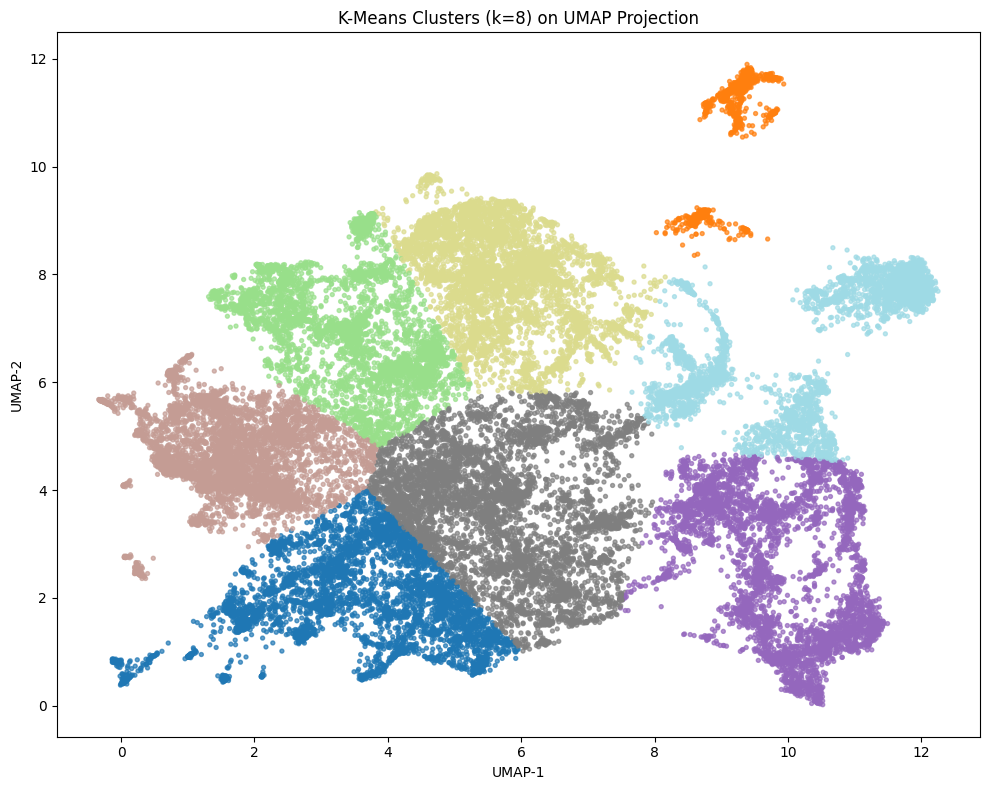

In [68]:
# Plot K-Means clusters on UMAP projection

plt.figure(figsize=(10,8))
plt.scatter(
    df["umap_x"], df["umap_y"],
    c=df["kmeans_cluster"],
    cmap="tab20",
    s=8,
    alpha=0.7
)
plt.title(f"K-Means Clusters (k={k}) on UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


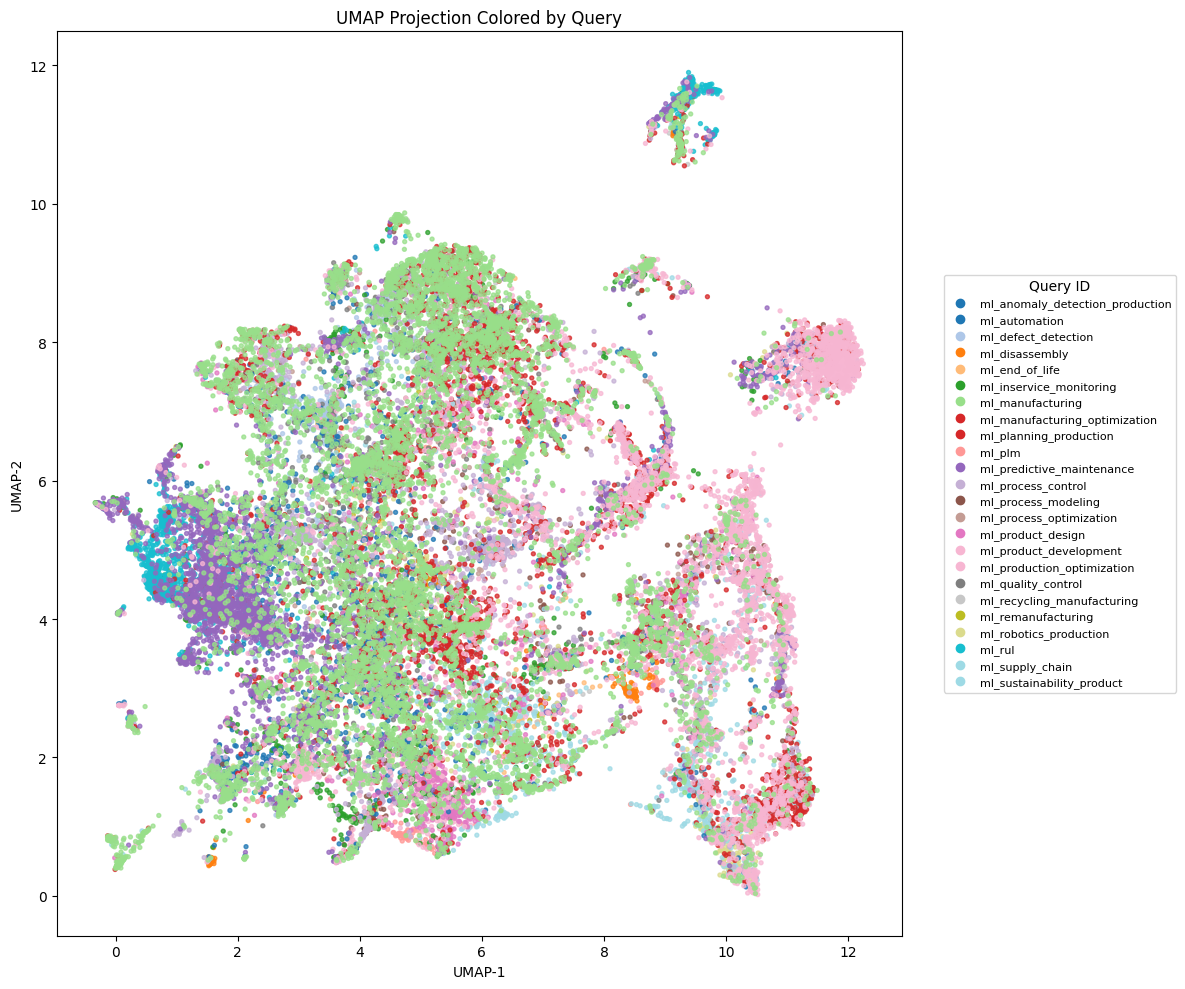

In [69]:
# Plot query_id distribution on UMAP projection

# Assign an integer color index to each query_id
query_ids = df["query_id"].astype("category")
query_labels = query_ids.cat.codes  # numeric mapping

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    df["umap_x"], df["umap_y"],
    c=query_labels,
    cmap="tab20",   # adjust depending on number of queries (>20 => use tab20b + tab20c)
    s=8,
    alpha=0.75
)

# Legend mapping numeric labels → query_id names
handles = []
for code, name in enumerate(query_ids.cat.categories):
    handles.append(
        plt.Line2D([], [], marker="o", linestyle="", 
                   color=scatter.cmap(scatter.norm(code)), label=name)
    )

plt.legend(
    handles=handles,
    title="Query ID",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.,
    fontsize=8
)

plt.title("UMAP Projection Colored by Query")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [80]:
domain_stopwords = {
    # Generic ML terms
    "machine learning", "ml", "deep learning", "data", "dataset", "model",
    "models", "method", "methods", "technique", "techniques", 'machine',
    "approach", "algorithm", "algorithms", "neural network",
    "artificial neural network", "support vector machine",
    "random forest", "learning approach", "learning algorithms",
    "deep learning models", "convolutional neural network", 'machine learning approach', 
    'machine learning techniques', 'machine learning models', 'machine learning algorithms', 'machine learning methods', 
    'machine learning approach', 'neural network model', 'Support Vector Regression', 'extreme learning machine', 
    'learning models', 'advanced machine learning', 'machine learning tools', 'ai',
    

    # Publisher names + garbage
    "springer nature switzerland", "springer nature singapore",
    "elsevier", "ieee", "wiley", "mdpi",
    
    "based", 'system', 'systems', 'using', 'paper', 'tool'
}

In [71]:
# kw_extractor = yake.KeywordExtractor(
#     lan="en",
#     n=3,  # max length of keyword: allows bigrams & trigrams
#     top=20,
#     dedupLim=0.3
# )

# def get_cluster_keywords(cluster_id, top_k=10):
#     texts = df[df["kmeans_cluster"] == cluster_id]["clean_abs"].tolist()
#     full_text = " ".join(texts)
    
#     keywords = kw_extractor.extract_keywords(full_text)
#     keywords = [
#         kw for kw, score in sorted(keywords, key=lambda x: x[1])
#         if kw.lower() not in domain_stopwords
#     ]
    
#     return keywords[:top_k]

# for cid in range(k):
#     print(f"\nCluster {cid}:")
#     print(get_cluster_keywords(cid, 12))



In [81]:
# Fit TF-IDF on all abstracts once
vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=5,
    ngram_range=(1, 3),
    stop_words="english"
)
X = vectorizer.fit_transform(df["clean_abs"].astype(str))
feature_names = np.array(vectorizer.get_feature_names_out())


In [82]:
def get_cluster_tfidf_keywords(cluster_id, top_k=15):
    # Boolean mask as numpy array (needed for sparse matrix indexing)
    mask = (df["kmeans_cluster"] == cluster_id).values
    if mask.sum() == 0:
        return []

    X_cluster = X[mask]

    # Mean TF-IDF score per term in this cluster
    mean_tfidf = np.asarray(X_cluster.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[::-1]

    keywords = []
    for idx in top_idx:
        kw = feature_names[idx].lower()
        if kw in domain_stopwords:
            continue
        keywords.append(kw)
        if len(keywords) == top_k:
            break

    return keywords

# Test on a few clusters
for cid in range(k):
    print(f"\nCluster {cid}:")
    print(get_cluster_tfidf_keywords(cid, 12))


Cluster 0:
['iot', 'security', 'manufacturing', 'service', 'industry', 'smart', 'design', 'process', 'network', 'detection', 'attacks', 'industrial']

Cluster 1:
['battery', 'concrete', 'batteries', 'rul', 'ion', 'lithium', 'prediction', 'lithium ion', 'strength', 'life', 'ion batteries', 'cement']

Cluster 2:
['process', 'manufacturing', 'quality', 'defect', 'machining', 'detection', 'inspection', 'defects', 'welding', 'surface', 'accuracy', 'time']

Cluster 3:
['food', 'production', 'crop', 'agricultural', 'water', 'yield', 'agriculture', 'study', 'process', 'quality', 'optimization', 'development']

Cluster 4:
['maintenance', 'predictive maintenance', 'predictive', 'fault', 'detection', 'failure', 'equipment', 'time', 'rul', 'industrial', 'monitoring', 'proposed']

Cluster 5:
['manufacturing', 'production', 'control', 'process', 'industry', 'supply', 'research', 'time', 'study', 'digital', 'scheduling', 'energy']

Cluster 6:
['process', 'manufacturing', 'design', 'materials', 'addi

In [78]:
# Dominant query per cluster
df.groupby("kmeans_cluster")["query_id"].apply(
    lambda x: x.value_counts().idxmax()
)

kmeans_cluster
0              ml_manufacturing
1                        ml_rul
2              ml_manufacturing
3    ml_production_optimization
4     ml_predictive_maintenance
5              ml_manufacturing
6              ml_manufacturing
7    ml_production_optimization
Name: query_id, dtype: object

In [87]:
# Get top 1 most representative article per K-Means cluster (title + DOI only)

def get_representative_top1(df, embeddings, cluster_col="kmeans_cluster"):
    reps = []

    for cid in sorted(df[cluster_col].unique()):
        mask = (df[cluster_col] == cid).values
        if mask.sum() == 0:
            continue

        emb_sub = embeddings[mask]
        centroid = emb_sub.mean(axis=0, keepdims=True)
        sims = cosine_similarity(emb_sub, centroid).ravel()

        best_local = sims.argmax()
        global_idx = df.index[mask][best_local]

        reps.append({
            "cluster": cid,
            "similarity": sims[best_local],
            "query_id": df.at[global_idx, "query_id"],
            "title": df.at[global_idx, "title"],
            "doi": df.at[global_idx, "doi"]
        })

    return pd.DataFrame(reps)

# Compute
rep_top1 = get_representative_top1(df, embeddings)

for _, row in rep_top1.sort_values("cluster").iterrows():
    print(f"\n Cluster {row['cluster']} ")
    print(f"Similarity: {row['similarity']:.3f}")
    print(f"Query: {row['query_id']}")
    print(f"Title: {row['title']}")
    if pd.notna(row['doi']):
        print(f"DOI: https://doi.org/{row['doi']}")
    else:
        print("DOI: Not available")




 Cluster 0 
Similarity: 0.856
Query: ml_manufacturing
Title: Applied Learning Algorithms for Intelligent IoT
DOI: https://doi.org/10.1201/9781003119838

 Cluster 1 
Similarity: 0.878
Query: ml_rul
Title: Overview of machine learning methods for lithium-ion battery remaining useful lifetime prediction
DOI: https://doi.org/10.3390/electronics10243126

 Cluster 2 
Similarity: 0.877
Query: ml_quality_control
Title: Industry 4.0: Why Machine Learning Matters?
DOI: https://doi.org/10.1007/978-981-15-9199-0_37

 Cluster 3 
Similarity: 0.814
Query: ml_supply_chain
Title: AI and data science in sustainable agriculture and food production
DOI: https://doi.org/10.4018/979-8-3693-6829-9.ch005

 Cluster 4 
Similarity: 0.911
Query: ml_predictive_maintenance
Title: Predictive Analysis Development Using Machine Learning for Industrial Equipments
DOI: https://doi.org/10.1109/INCIP64058.2025.11020528

 Cluster 5 
Similarity: 0.874
Query: ml_automation
Title: Implementation of Artificial Intelligence an

In [84]:
# Compute dominant cluster statistics per query_id

# Basic group for top cluster per query
query_cluster_stats = (
    df.groupby("query_id")
      .agg(
          total_in_query=("kmeans_cluster", "size"),
          top_cluster=("kmeans_cluster", lambda x: x.value_counts().idxmax())
      )
)


def compute_both_shares(row):
    qid = row.name
    top_c = row["top_cluster"]

    # All articles for this query
    subset_query = df[df["query_id"] == qid]
    top_count_query = (subset_query["kmeans_cluster"] == top_c).sum()

    # All articles in top cluster
    subset_cluster = df[df["kmeans_cluster"] == top_c]
    top_count_cluster = (subset_cluster["query_id"] == qid).sum()

    share_of_query = top_count_query / row["total_in_query"]
    share_of_cluster = top_count_cluster / len(subset_cluster)

    return pd.Series([
        top_count_query,
        share_of_query,
        share_of_cluster,
        len(subset_cluster)
    ], index=[
        "top_count_query",
        "share_of_query",
        "share_of_cluster",
        "total_in_cluster"
    ])


# Apply computation
query_cluster_stats = query_cluster_stats.join(
    query_cluster_stats.apply(compute_both_shares, axis=1)
)

# Sort by how dominant cluster is for this query
query_cluster_stats = query_cluster_stats.sort_values("share_of_query", ascending=False)

query_cluster_stats


,total_in_query,top_cluster,top_count_query,share_of_query,share_of_cluster,total_in_cluster
query_id,,,,,,
ml_end_of_life,51,5,34.0,0.666667,0.006189,5494.0
ml_rul,1405,4,896.0,0.637722,0.185892,4820.0
ml_predictive_maintenance,3050,4,1936.0,0.634754,0.401660,4820.0
ml_defect_detection,610,2,348.0,0.570492,0.089737,3878.0
ml_remanufacturing,99,5,53.0,0.535354,0.009647,5494.0
ml_process_optimization,572,6,282.0,0.493007,0.057692,4888.0
ml_disassembly,271,3,124.0,0.457565,0.026411,4695.0
ml_plm,229,0,99.0,0.432314,0.020798,4760.0
ml_supply_chain,707,5,305.0,0.431400,0.055515,5494.0
